Deep Neural network based estimation for S and P wave arrival time
==

In [19]:
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [20]:
%matplotlib inline

In [21]:
# visualizacion
import matplotlib.pylab as plt
import seaborn as sns

sns.set(style="ticks")

In [22]:
# librerias cientificas basicas de python
import numpy as np # matrix operations
import pandas as pd # dataframes
from os import listdir # dir handler
from os.path import isfile, join # file operations
from tqdm import tqdm

In [23]:
# libreria de redes neuronales
from keras.models import Sequential
from keras.layers import Dense

In [24]:
# libreria sismica desarrollada
import sys
sys.path.append('./../python-packages')
from seismic_source import SeismicEvent
from seismic_source import SeismicEvent 

Este es un ejemplo de señal sísmica para el campo de desplazamiento, la linea azul más a la izquiera es el tiempo de llegada de la onda P y la linea vertical más a la derecha es el tiempo de llegada de la onda s.

In this example a seismic signal for the displacement field is drawed in red-green-blue curves

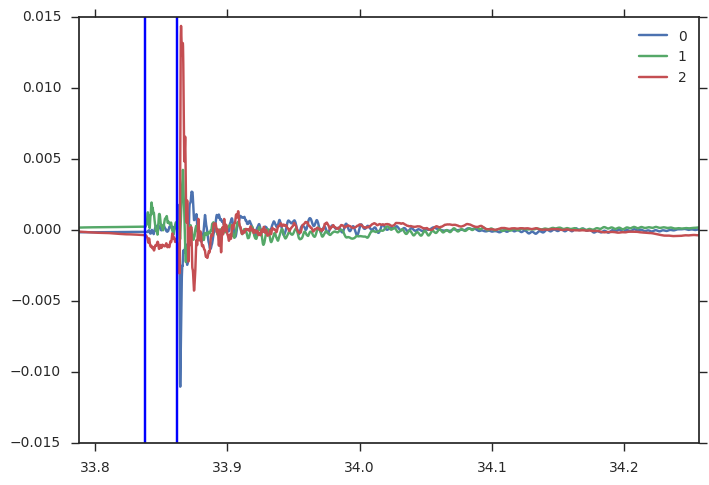

In [25]:
e = SeismicEvent.evento("../data-sets/1998_aug_07_16_24_33.i6b")
seis_info = e.seismograms[1]
seis_info.data.plot()
plt.axvline(x=seis_info.data.index[seis_info.P_pick])
plt.axvline(x=seis_info.data.index[seis_info.S_pick])

Estimación de la llegada de la onda p y s
==
Usaremos una red neuronal para estimar el tiempo de llegada de la onda P y S

## construcción de los datos de entrenamiento
A partir de la información manual proveniente de codelco, entrenamos una red neurola para estimar el tiempo de llegada de la onda S y la onda P. El primer paso es contruir los datos de entrenamiento

In [ ]:
%%time
mypath = "../data-sets"
trainning_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

u = int(0.7*len(trainning_files))

validation_files = list(set(trainning_files) - set(trainning_files[0:u]))
trainning_files = trainning_files[0:u]

"""
Objetivo: Generar los datos de entrenamiento
Secuencia de pasos

0. Seleccionar un sismograma de un evento sismico

1. Agregar columnas con un cumsum del cuadrado de los datos dividido por el maximo del cumsum
   de los cuadrados de los datos que representa el porcentaje de energía en el tiempo
   (información global)
   
2. Seleccionar los datos del sismograma

3. Generar una columna indicando el indice en donde ocurre la llegada de la onda P

4. Generar una columna indicando el indice en donde ocurre la llegada de la onda S

5. eliminar el indice temporal para generar un indice autoincremental

6. Seleccionar un ancho de ventana de datos para el sismo

7. Separar las entradas y las salidas en los datos de entrenamiento

"""
trainning_cases = []

n = 500                                                                      # (6)
for t in trainning_files:
    e = SeismicEvent.evento("../data-sets/" + t)
    for i, seismogram in enumerate(e.seismograms):

        data = seismogram.data                                               # (1)

        data['Energy'] = (data**2).cumsum().sum(axis=1)                      # (2)
        data['Energy'].plot()
        
        p_indicator = np.zeros(data.shape[0])
        p_indicator[e.seismograms[0].P_pick] = 1 
        p_df = pd.DataFrame(data= p_indicator, index=data.index) 
        data['p'] = p_df                                                     # (3)

        s_indicator = np.zeros(data.shape[0])
        s_indicator[e.seismograms[0].S_pick] = 1 
        s_df = pd.DataFrame(data= s_indicator, index=data.index) 
        data['s'] = s_df                                                    # (4)

        data.index = pd.DataFrame(range(data.index.values.shape[0]))        # (5)

        N = data.shape[0]
        for i in np.arange(N - n):
            case = data[i:(i + n)]
            trainning_case = np.hstack((case[0].values,
                                       case[1].values,
                                       case[2].values,
                                       case['Energy'].values,
                                       case.p.sum(),
                                       case.s.sum()))
            trainning_cases.append(trainning_case)

In [ ]:
final_trainning_data = np.vstack(trainning_cases)
#np.save(file='./trainning_data', arr = final_trainning_data)
#final_trainning_data = np.load(file='./trainning_data.npy')
X = final_trainning_data[:, 0:(6*n)] 
Y = final_trainning_data[:, 6*n:(6*n+2)] # (7)

In [11]:
model = Sequential()
model.add(Dense(X.shape[1], input_dim=X.shape[1], init='uniform', activation='sigmoid'))
#model.add(Dense(8, init='uniform', activation='relu'))
model.add(Dense(2, init='uniform', activation='sigmoid'))

NameError: name 'X' is not defined

In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X, Y, nb_epoch=100, batch_size=10)

Epoch 1/100
347970/847091 [===========>..................] - ETA: 132s - loss: nan - acc: 0.0000e+00    50/847091 [..............................] - ETA: 917s - loss: nan - acc: 0.0100 

In [21]:
model.save_weights('./model_weights.h5')

In [ ]:
X.shape[1]

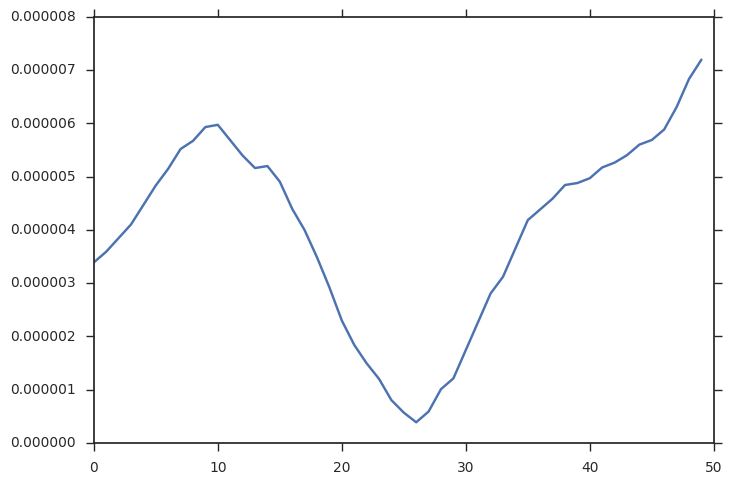

In [59]:
x = X[200,0:n]
plt.plot(x)

In [53]:
#x = x.reshape((1,300))
print 'evaluando la red'
predictions = model.predict(x)

#plt.plot(predictions)

evaluando la red


Exception: Error when checking : expected dense_input_1 to have shape (None, 300) but got array with shape (0, 50)

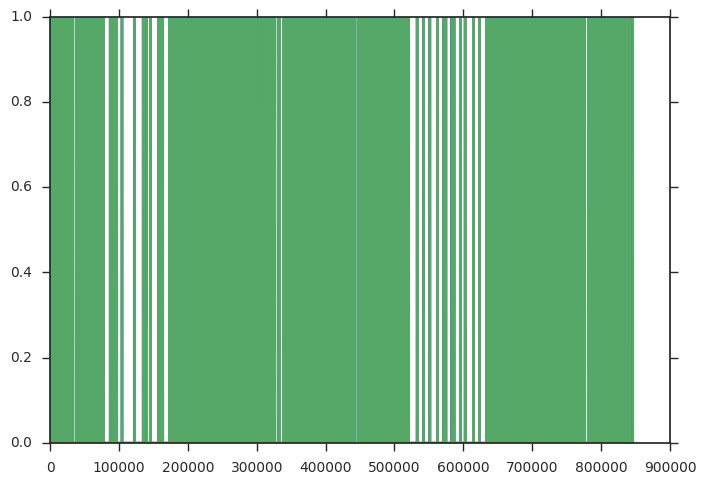

In [20]:
plt.plot(Y)

In [2]:
from ipywidgets import FloatProgress
from IPython.display import display

In [3]:
f = FloatProgress(min=0, max=100)
display(f)

In [4]:
import ipywidgets as widgets
widgets.HTML(value="Hello <b>World</b>")